In [ ]:
"""
Author: Ze Hong Wu
Purpose: Part of the CSCI 49377 project's Stage 4 training process.
This notebook will subject a DenseNet-based model through a number of changes.
"""

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from glob import glob
import random


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, MaxPool2D, Dense, Dropout, Flatten, Reshape, GlobalAveragePooling2D, CenterCrop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers.legacy import Adam
# https://stackoverflow.com/questions/71153492/invalid-argument-error-graph-execution-error
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU, Add, Activation, SeparableConv2D, Concatenate, AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

## Preprocessing

Preparing the datasets and setting some useful constants.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords

ls: cannot access '/content/drive/MyDrive/49377_tfrecords': No such file or directory


In [ ]:
TFR_PATH = "/content/drive/MyDrive/49377_tfrecords/"
# Using an absolute path based on this one rumor I heard

## DO NOT MOVE THIS CELL ANY LOWER; parse function needs labels
image_shape = (512, 512, 3)
labels = ['dog', 'tiger', 'house', 'bell', 'horse']

In [ ]:
def _parse_function(example):
    # Define your tfrecord again. The contents should be adjusted according to how you wrote your tfrecord file.
    keys_to_features = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image as a raw byte string
        'label': tf.io.FixedLenFeature([], tf.int64),     # Label as an integer
    }

    # Parse the input `tf.train.Example` using the feature description dictionary above
    parsed_features = tf.io.parse_single_example(example, keys_to_features)

    # Decode the image data into an array
    image = tf.image.decode_png(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0

    # We will use one-hot enocded labels
    label = parsed_features['label']
    label = tf.one_hot(label, depth=len(labels), dtype=tf.int64)

    return image, label

In [ ]:
def load_tfrecord_dataset(tfrecord_file, batch_size=32):
    # Load the dataset
    dataset = tf.data.TFRecordDataset(tfrecord_file, num_parallel_reads=tf.data.AUTOTUNE)


    # Parse the serialized data in the TFRecords
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(3 * batch_size)

    # Set the batch size
    dataset = dataset.batch(batch_size, drop_remainder=True)

    # Prefetch will enable the input pipeline to asynchronously fetch batches while the model is training
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [ ]:
#Paths to the TFRecord files

train_file = TFR_PATH + 'train.tfrecord'
val_file = TFR_PATH + 'val.tfrecord'
# I initially had the valid tfrecord named "valid.tfrecord"
# but model.fit() below insisted on looking for "val.tfrecord" during validation session
# (despite me manually passing it X_val for validation),
# which led to a Graph Execution Error and many open tabs trying to fix this bug.
# I don't know why this is the case and it's too late at night for me to be figuring that out.
test_file = TFR_PATH + 'test.tfrecord'

# Loading the datasets
X_train = load_tfrecord_dataset(train_file)
X_val = load_tfrecord_dataset(val_file)
X_test = load_tfrecord_dataset(test_file)

In [ ]:
type(X_test)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# https://stackoverflow.com/questions/67878735/how-to-change-the-dtype-of-data-in-tf-data-dataset
# The labels are in int64 format but the model outputs are in float32
# Macro F1Score doesn't work when that is the case
# I am casting the labels to float32
X_train = X_train.map(lambda x, y: (x, tf.cast(y, tf.float32)))
X_val = X_val.map(lambda x, y: (x, tf.cast(y, tf.float32)))
X_test = X_test.map(lambda x, y: (x, tf.cast(y, tf.float32)))

<class 'tensorflow.python.framework.ops.EagerTensor'>


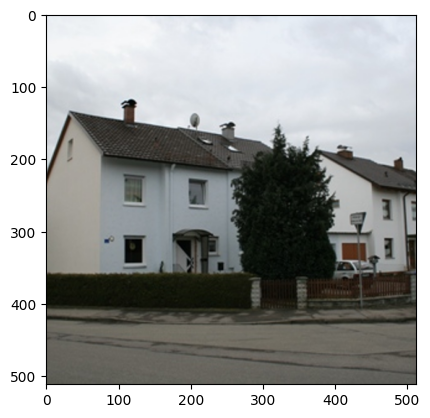

tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


In [ ]:
dataset_batch = X_test.take(1)

# Take the first batch from the dataset
# Remember to usr take(1) and not take(0)
# label values are: ['dog', 'tiger', 'house', 'bell', 'horse']
for batch, label in dataset_batch.take(1):
    # Extract the first image from the batch
    # print("is loop running?")
    image = batch[0]  # This gets the first image in the batch
    print(type(image))

    # The image tensor shape is (512, 512, 3), you can now visualize it
    plt.imshow(image)
    plt.show()
    print(label[0])

In this Stage 4 testing, I will experiment with the following: gradient clipping, activation functions, growth rate, compression factor, epoch count,learning rate, and other architecture changes I may decide on.

In [ ]:
def make_densenet(filters=32, compression_factor=0.5, repetitions=[3,6,12,8], activation="relu",
                  optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1,)):
  """
  This function generates, compiles, and returns a DenseNet CNN model using the given hyperparameters.
  """
  clear_session()
  # This is a shrunk down version of the DenseNet-121 architecture.
  # The number of Conv blocks have been halved across the board.
  # Without this change, the Colab instance would consume all RAM and crash when training.
  # filters=32
  # compression_factor=0.5
  input = Input(shape=image_shape)
  x = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation=activation)(input)
  x = MaxPool2D(pool_size=(3,3), strides=2, padding="same")(x)

  # Conv blocks
  # repetitions = [3,6,12,8]

  for repetition in repetitions:
    for i in range(repetition):
      y = BatchNormalization()(x)
      # placeholder comment
      match activation:
        case "relu":
          y = ReLU()(y)
        case "leaky_relu":
          y = LeakyReLU()(y)
        case default:
          y = ReLU()(y)
      y = Conv2D(filters=filters*4, kernel_size=1, strides=1, padding = 'same')(y)
      y = BatchNormalization()(y)
      match activation:
        case "relu":
          y = ReLU()(y)
        case "leaky_relu":
          y = LeakyReLU()(y)
        case default:
          y = ReLU()(y)
      #y = activation(y)
      y = Conv2D(filters=filters, kernel_size=3, strides=1, padding = 'same')(y)
      x = Concatenate()([y,x])
    if repetition != repetitions[len(repetitions)-1]: # last conv block doesn't get a transition layer
      x = BatchNormalization()(x)
      match activation:
        case "relu":
          xx = ReLU()(x)
        case "leaky_relu":
          x = LeakyReLU()(x)
        case default:
          x = ReLU()(x)
      x = Conv2D(filters=int(x.shape[-1]*compression_factor), kernel_size=1, strides=1, padding = 'same')(x)
      x = AveragePooling2D(pool_size=(2,2), strides=2, padding="same")(x)

  x = GlobalAveragePooling2D()(x)
  output = Dense(5, activation="softmax")(x)

  #optim = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)

  my_densenet = Model(inputs=input, outputs=output)
  my_densenet.compile(optimizer=optimizer,
                      # learning rate as chosen by authors for ImageNet
                      metrics=["accuracy", F1Score(average="macro")], loss="categorical_crossentropy")
  return my_densenet

In [ ]:
num_epochs = 24 # arbitrarily decided epoch count
batch_size = 32
train_samples_count = 18000
steps_per_epoch = train_samples_count // batch_size

In [ ]:
from tensorflow import random
np.random.seed(42)
random.set_seed(42)

## Explanation of Work

Each section in the table of contents after "Summary Statistics" describes a block of code where I tested out a feature and then evaluated the model's performance.

## Summary Statistics

This table stores the information on attempted changes to the DenseNet model architecture.

Loss, Accuracy, and F1 are derived from evaluating the models against the training set.

Model name | Previous model name | Changes made | loss | accuracy | f1
--- | --- | --- | --- | --- | ---
my_densenet | none | Original from Stage 3 | 0.6446 | 0.7686 | 0.7696
initial_densenet | my_densenet | see [1] | 0.5793 | 0.8049 | 0.8041
clipnorm_densenet | initial_densenet | Added clipnorm=1.0 to optimizer | 0.5196 | 0.8424 | 0.8404
leaky_densenet | clipnorm_densenet | Using Leaky ReLU activation | 0.4755 | 0.8263 | 0.8245
compression_densenet | clipnorm_densenet | Using compression_factor=0.66 | 0.4658 | 0.8433 | 0.8422
filters_densenet | compression_densenet | Using filters=48 | 0.5159 | 0.8277 | 0.8252
learning_densenet | compression_densenet | Using modified learning rate | 0.5168 | 0.8134 | 0.8141

[1]: Removed incorrectly added transition layer, corrected learning rate adjustment, trained model for 24 epochs

## Initial Densenet

This version removes the incorrectly added transition layer, corrects the learning rate adjustment to match the numbers in the DenseNet paper, and trains the model for 24 epochs.

In [ ]:
initial_densenet = make_densenet()

In [ ]:
# my_densenet = make_densenet()
initial_densenet._name = "DenseNet"
initial_densenet.summary()

Model: "DenseNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_pooling2d[0][0]']

In [ ]:
current_densenet_filename = "stage4/densenet_init_best_model_val_loss.keras"

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = initial_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 209s 309ms/step - loss: 1.9315 - accuracy: 0.2676 - f1_score: 0.2599
Epoch 1: val_loss improved from inf to 1.96549, saving model to /content/drive/MyDrive/49377_tfrecords/densenet/initial_densenet_best_model_val_loss.keras
562/562 [==============================] - 236s 358ms/step - loss: 1.9315 - accuracy: 0.2676 - f1_score: 0.2599 - val_loss: 1.9655 - val_accuracy: 0.3415 - val_f1_score: 0.2890 - lr: 0.1000
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3736 - accuracy: 0.4272 - f1_score: 0.4169
Epoch 2: val_loss improved from 1.96549 to 1.37027, saving model to /content/drive/MyDrive/49377_tfrecords/densenet/initial_densenet_best_model_val_loss.keras
562/562 [==============================] - 86s 152ms/step - loss: 1.3736 - accuracy: 0.4272 - f1_score: 0.4169 - val_loss: 1.3703 - val_accuracy: 0.4290 - val_f1_score: 0.3487 - lr: 0.1000
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.2678 - accuracy: 0.483

In [ ]:
# example evaluating with tf.data.Dataset
scores = initial_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 25s 357ms/step - loss: 0.5793 - accuracy: 0.8049 - f1_score: 0.8041


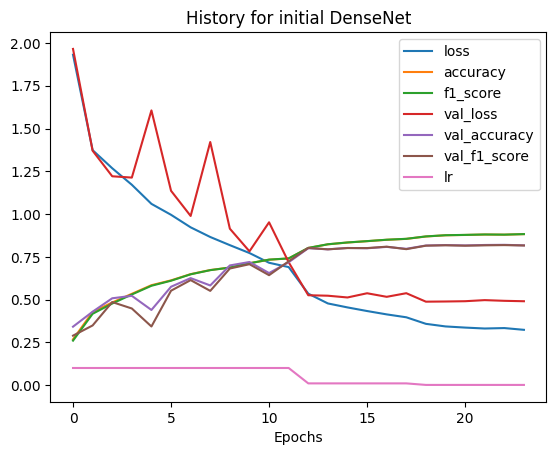

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for initial DenseNet")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage4/densenet_init_losses_over_time.png")
plt.show()

In [ ]:
! pip install visualkeras
# nifty little package for visualizing a .keras model without having to fiddle with LaTeX files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.6 MB/s eta 0:00:00


##clipnorm-densenet:
Testing the effects of gradient clipping (clipnorm=1.0) on the model's accuracy.

In [ ]:
clipnorm_optimizer = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)
clipnorm_densenet = make_densenet(optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0))
clipnorm_densenet._name = "DenseNet_with_clipNorm"
clipnorm_densenet.summary()
# didn't change architecture so no need to change that

Model: "DenseNet_with_clipNorm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_poo

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage4/clipnorm_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = clipnorm_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 343s 513ms/step - loss: 1.6030 - accuracy: 0.3173 - f1_score: 0.3119
Epoch 1: val_loss improved from inf to 1.72189, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/clipnorm_densenet_best_model_val_loss.keras
562/562 [==============================] - 377s 573ms/step - loss: 1.6030 - accuracy: 0.3173 - f1_score: 0.3119 - val_loss: 1.7219 - val_accuracy: 0.4496 - val_f1_score: 0.4096 - lr: 0.1000
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3438 - accuracy: 0.4456 - f1_score: 0.4378
Epoch 2: val_loss improved from 1.72189 to 1.32646, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/clipnorm_densenet_best_model_val_loss.keras
562/562 [==============================] - 295s 522ms/step - loss: 1.3438 - accuracy: 0.4456 - f1_score: 0.4378 - val_loss: 1.3265 - val_accuracy: 0.4750 - val_f1_score: 0.3964 - lr: 0.1000
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.2183 - accuracy: 0.5092

In [ ]:
# example evaluating with tf.data.Dataset
# saved_densenet = load_model(TFR_PATH+"stage4/clipnorm_densenet_best_model_val_loss.keras")
scores = clipnorm_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 36s 442ms/step - loss: 0.5196 - accuracy: 0.8424 - f1_score: 0.8404


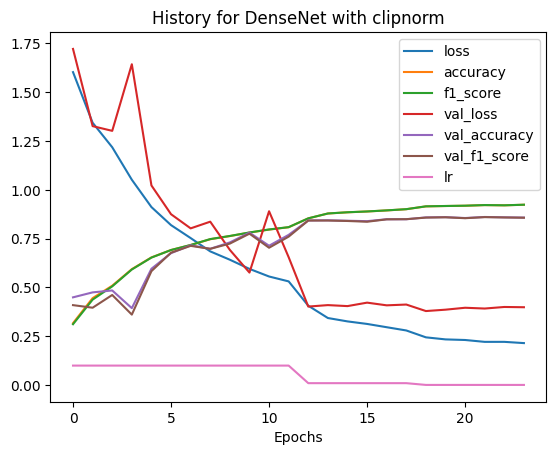

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with clipnorm")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage4/clipnorm_densenet_losses_over_time.png")
plt.show()

In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords/stage4

clipnorm_densenet_best_model_val_loss.keras  initial_densenet_best_model_val_loss
clipnorm_densenet_losses_over_time.png	     initial_densenet_best_model_val_loss.keras
densenet_init_losses_over_time.png


## leaky-densenet:

DenseNet model with Leaky ReLU activation.

In [ ]:
clipnorm_optimizer = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)
leaky_densenet = make_densenet(optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0),
                              activation="leaky_relu"
                              )
leaky_densenet._name = "DenseNet_with_LeakyReLU" # whitespaces are not allowed in tf model names
leaky_densenet.summary()

Model: "DenseNet_with_LeakyReLU"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_po

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage4/leaky_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = leaky_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 300s 451ms/step - loss: 1.5776 - accuracy: 0.3830 - f1_score: 0.3814
Epoch 1: val_loss improved from inf to 11.33383, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/leaky_densenet_best_model_val_loss.keras
562/562 [==============================] - 344s 529ms/step - loss: 1.5776 - accuracy: 0.3830 - f1_score: 0.3814 - val_loss: 11.3338 - val_accuracy: 0.2357 - val_f1_score: 0.1256 - lr: 0.1000
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.5182 - f1_score: 0.5172
Epoch 2: val_loss improved from 11.33383 to 3.49285, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/leaky_densenet_best_model_val_loss.keras
562/562 [==============================] - 286s 506ms/step - loss: 1.1889 - accuracy: 0.5182 - f1_score: 0.5172 - val_loss: 3.4929 - val_accuracy: 0.3835 - val_f1_score: 0.3011 - lr: 0.1000
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.0431 - accuracy: 0.5935 - 

In [ ]:
# example evaluating with tf.data.Dataset
scores = leaky_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 31s 394ms/step - loss: 0.4755 - accuracy: 0.8263 - f1_score: 0.8245


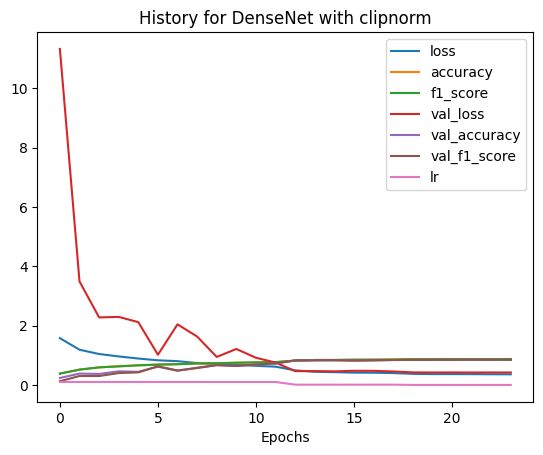

In [ ]:
"""
README

The title in the image is wrong and I forgot to update it properly when copying from the clipnorm cells
I will edit the image to correct the title on my own outside of this notebook.
"""

import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with Leaky ReLU")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage4/leaky_densenet_losses_over_time.png")
plt.show()

In [ ]:
! ls /content/drive/MyDrive/49377_tfrecords/stage4

clipnorm_densenet_best_model_val_loss.keras  initial_densenet_best_model_val_loss.keras
clipnorm_densenet_losses_over_time.png	     leaky_densenet_best_model_val_loss.keras
densenet_init_losses_over_time.png	     leaky_densenet_losses_over_time.png
initial_densenet_best_model_val_loss


## compression-densenet

DenseNet model with 0.66 compression factor instead of 0.5. This means that, after each transition layer, the model will have 2/3 as many filters as before the layer instead of 1/2. This model will build off of the clipnorm-densenet model structure, since the experimental observations for leaky-densenet looks subpar.

In [ ]:
clipnorm_optimizer = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)
compression_densenet = make_densenet(optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0), compression_factor=0.66)
compression_densenet._name = "DenseNet_with_new_compression_rate"
compression_densenet.summary()
# didn't change architecture so no need to change that

Model: "DenseNet_with_new_compression_rate"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256    

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage4/compression_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = compression_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 311s 468ms/step - loss: 1.6110 - accuracy: 0.3441 - f1_score: 0.3380
Epoch 1: val_loss improved from inf to 1.70992, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/compression_densenet_best_model_val_loss.keras
562/562 [==============================] - 344s 528ms/step - loss: 1.6110 - accuracy: 0.3441 - f1_score: 0.3380 - val_loss: 1.7099 - val_accuracy: 0.3487 - val_f1_score: 0.2237 - lr: 0.1000
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.2579 - accuracy: 0.4875 - f1_score: 0.4824
Epoch 2: val_loss did not improve from 1.70992
562/562 [==============================] - 270s 478ms/step - loss: 1.2579 - accuracy: 0.4875 - f1_score: 0.4824 - val_loss: 3.9680 - val_accuracy: 0.4241 - val_f1_score: 0.3732 - lr: 0.1000
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.0834 - accuracy: 0.5768 - f1_score: 0.5751
Epoch 3: val_loss improved from 1.70992 to 1.19031, saving model to /content/drive/MyDri

In [ ]:
# example evaluating with tf.data.Dataset
scores = compression_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 31s 416ms/step - loss: 0.4658 - accuracy: 0.8433 - f1_score: 0.8422


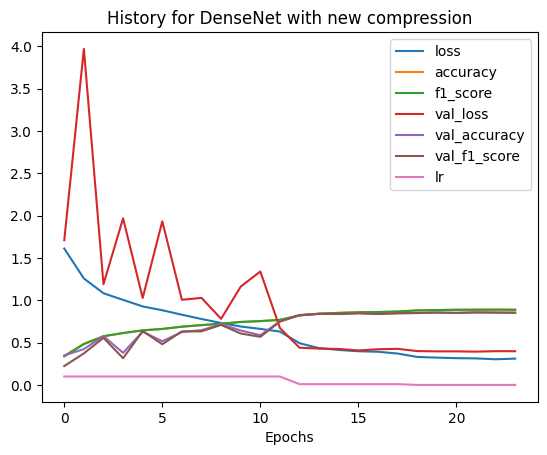

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with new compression")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage4/compression_densenet_losses_over_time.png")
plt.show()

## filters-densenet

DenseNet with a filters value of 48 instead of 32. The value for filters determines how much the number of filters grows per residual unit in a dense block.

In [ ]:
clipnorm_optimizer = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)
filters_densenet = make_densenet(optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0),
                                     compression_factor=0.66, # this seems to make the model marginally better so let's go with that
                                     filters=48 # new filters value
                                     )
filters_densenet._name = "DenseNet_with_48_filters"
filters_densenet.summary()
# didn't change architecture so no need to change that

Model: "DenseNet_with_48_filters"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max_p

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage4/filters_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.1
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = filters_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 335s 499ms/step - loss: 1.7663 - accuracy: 0.2874 - f1_score: 0.2845
Epoch 1: val_loss improved from inf to 13.82640, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/filters_densenet_best_model_val_loss.keras
562/562 [==============================] - 380s 579ms/step - loss: 1.7663 - accuracy: 0.2874 - f1_score: 0.2845 - val_loss: 13.8264 - val_accuracy: 0.3232 - val_f1_score: 0.2759 - lr: 0.1000
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.4865 - accuracy: 0.3851 - f1_score: 0.3782
Epoch 2: val_loss improved from 13.82640 to 1.36178, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/filters_densenet_best_model_val_loss.keras
562/562 [==============================] - 289s 512ms/step - loss: 1.4865 - accuracy: 0.3851 - f1_score: 0.3782 - val_loss: 1.3618 - val_accuracy: 0.4263 - val_f1_score: 0.4337 - lr: 0.1000
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.3240 - accuracy: 0.455

In [ ]:
# example evaluating with tf.data.Dataset
scores = filters_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 31s 406ms/step - loss: 0.5159 - accuracy: 0.8277 - f1_score: 0.8252


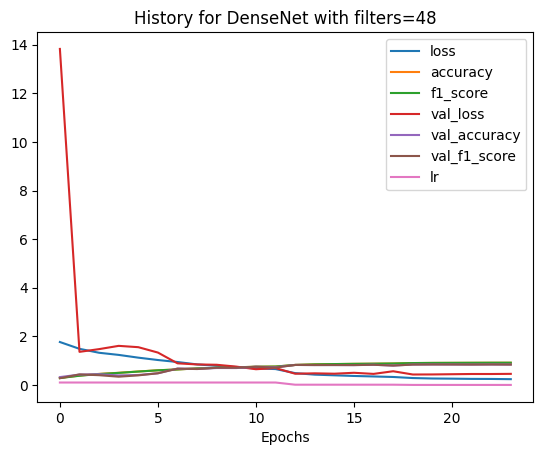

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with filters=48")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage4/filters_densenet_losses_over_time.png")
plt.show()

#learning-rate-densenet

DenseNet with a modified learning rate program. From prior observations, learning seems to be slightly chaotic prior to the halfway point and peter out after the halfway point where the learning rate gets slashed by 90%. This version will reduce the learning rate by 50% instead of 90% at the halfway and 3/4 points of the training epochs.

In [ ]:
clipnorm_optimizer = SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0)
learning_densenet = make_densenet(optimizer=SGD(momentum=0.9, weight_decay = 0.00001, learning_rate=0.1, clipnorm=1.0),
                                     compression_factor=0.66,
                                     filters=32
                                     )
learning_densenet._name = "DenseNet_with_new_learning"
learning_densenet.summary()
# didn't change architecture so no need to change that

Model: "DenseNet_with_new_learning"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['max

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
current_densenet_filename = "stage4/learning_densenet_best_model_val_loss.keras"
checkpoint = ModelCheckpoint(
    TFR_PATH+current_densenet_filename,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                           verbose=1, patience=4,
                           min_delta=0, restore_best_weights=True)
def schedule_func(epoch, lr):
  # Authors reduced lr by 90% at 50% and 75% mark of total training epochs
  # if epoch == 1: return 0.1
  if epoch == num_epochs//2 or epoch == int(num_epochs*0.75): return lr * 0.5 # reduce by 50%, not 90%
  else: return lr
lr_scheduler = LearningRateScheduler(schedule_func)

In [ ]:
# eliminating early stopping for now
history = learning_densenet.fit(X_train, epochs=num_epochs, validation_data=X_val, callbacks=[checkpoint, lr_scheduler])

Epoch 1/24
    562/Unknown - 275s 433ms/step - loss: 1.7204 - accuracy: 0.3371 - f1_score: 0.3336
Epoch 1: val_loss improved from inf to 6.09467, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/learning_densenet_best_model_val_loss.keras
562/562 [==============================] - 319s 511ms/step - loss: 1.7204 - accuracy: 0.3371 - f1_score: 0.3336 - val_loss: 6.0947 - val_accuracy: 0.3321 - val_f1_score: 0.2383 - lr: 0.1000
Epoch 2/24
562/562 [==============================] - ETA: 0s - loss: 1.3523 - accuracy: 0.4506 - f1_score: 0.4450
Epoch 2: val_loss improved from 6.09467 to 1.50652, saving model to /content/drive/MyDrive/49377_tfrecords/stage4/learning_densenet_best_model_val_loss.keras
562/562 [==============================] - 270s 478ms/step - loss: 1.3523 - accuracy: 0.4506 - f1_score: 0.4450 - val_loss: 1.5065 - val_accuracy: 0.4201 - val_f1_score: 0.3423 - lr: 0.1000
Epoch 3/24
562/562 [==============================] - ETA: 0s - loss: 1.1853 - accuracy: 0.5236

In [ ]:
# example evaluating with tf.data.Dataset
scores = learning_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 34s 450ms/step - loss: 0.7175 - accuracy: 0.8080 - f1_score: 0.8084


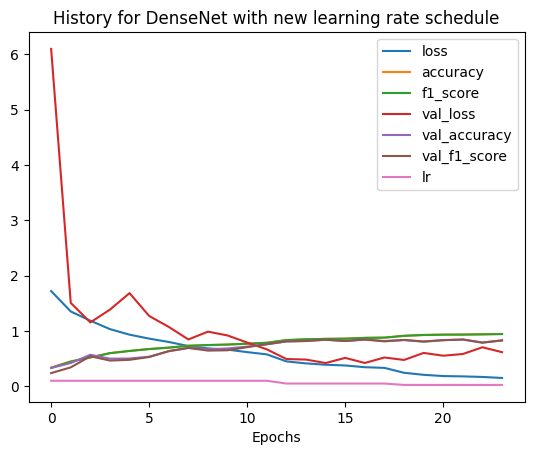

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Draw the losses over time using plt
losses = pd.DataFrame(history.history).plot();
plt.title("History for DenseNet with new learning rate schedule")
plt.xlabel("Epochs")
plt.savefig(TFR_PATH+"stage4/learning_densenet_losses_over_time.png")
plt.show()

Some code to visualize the model architecture.

In [ ]:
best_learning_densenet = load_model(TFR_PATH+"stage4/learning_densenet_best_model_val_loss.keras")
scores = best_learning_densenet.evaluate(X_test,
                              #steps=32
                              )

70/70 [==============================] - 42s 402ms/step - loss: 0.5168 - accuracy: 0.8134 - f1_score: 0.8141


In [ ]:
import visualkeras
from tensorflow.keras.saving import load_model
best_model_path = "stage4/initial_densenet_best_model_val_loss.keras"
densenet = load_model(TFR_PATH+best_model_path)
img = visualkeras.layered_view(densenet)
img

In [ ]:
from PIL import Image
# img = visualkeras.layered_view(densenet)
img.save(TFR_PATH+"stage4/stage4_densenet_model_architecture.png", "PNG")